# Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
%matplotlib inline
from math import floor
from scipy.special import softmax
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Plotting functions

In [2]:
def plot_Q(Q, message = "Q plot"):

    plt.figure(figsize=(10,10))
    plt.title(message)
    # print("Q.max(-1)", Q.max(-1))
    arr1 = np.zeros((10,10))
    arr2 = np.zeros((10,10))
    for i,q_val in enumerate(Q.max(-1)):
        r = floor(i/10)
        c = i - 10*r
        arr1[r,c] = q_val
        arr2[r,c] = np.argmax(Q[i])
    plt.pcolor(arr1, edgecolors='k', linewidths=2)
    plt.colorbar()
    def x_direct(a):
        if a in [0, 1]:
            return 0
        return 1 if a == 3 else -1
    def y_direct(a):
        if a in [2,3]:
            return 0
        return 1 if a == 1 else -1
    policy = arr2
    policyx = np.vectorize(x_direct)(policy)
    policyy = np.vectorize(y_direct)(policy)
    idx = np.indices(policy.shape)
    plt.quiver(idx[1].ravel()+0.5, idx[0].ravel()+0.5, policyx.ravel(), policyy.ravel(), pivot="middle", color='red')
    plt.show()

In [13]:
def plot_state_visits(state_step):
  plt.figure(figsize=(10,10))
  arr = np.zeros((10,10))
  for i,val in enumerate(state_step):
    r = floor(i/10)
    c = i - 10*r
    arr[r,c] = state_step[i]

  plt.title('Average State Visits per episode')
  sns.heatmap(arr,annot=True,cmap='YlGnBu')

In [3]:
def plot_goal_steps_and_rewards(episodes,alpha,gamma,param,env,choose_action):
  num_expts = 5
  reward_avgs, steps_avgs = [], []
  for i in range(num_expts):
    Q = np.zeros((env.num_states, env.num_actions))
    rg = np.random.RandomState(i)
    Q, rewards, steps , _ = ql(env, Q, episodes = episodes, gamma = gamma , alpha = alpha , policy_param = param , plot_heat=False, choose_action= choose_action)
    reward_avgs.append(list(rewards))
    steps_avgs.append(list(steps))

  reward_avgs2 = np.mean(np.array(reward_avgs),axis = 0)
  steps_avgs2 = np.mean(np.array(steps_avgs),axis = 0)
  reward_std = np.std(reward_avgs,axis= 0)
  step_std = np.std(steps_avgs,axis = 0)
  plt.figure()
  plt.xlabel('Episode')
  plt.ylabel('Steps to reach the goal')
  plt.plot(np.linspace(0,episodes,episodes),steps_avgs2,'r-',linewidth = 1)
  plt.fill_between(np.linspace(0,episodes,episodes),steps_avgs2+step_std,steps_avgs2-step_std)
  plt.show()

  plt.figure()
  plt.xlabel('Episode')
  plt.ylabel('Total Reward')
  plt.plot(np.linspace(0, episodes,episodes),reward_avgs2,'r-',linewidth = 1)
  plt.fill_between(np.linspace(0, episodes,episodes),reward_avgs2+reward_std,reward_avgs2-reward_std)
  plt.show()


# Action Policies

In [4]:
# policies

seed = 42
rg = np.random.RandomState(seed)

# Epsilon greedy
def choose_action_epsilon(Q, state, epsilon, rg=rg):
    if not Q[state].any() or rg.uniform(0,1) < epsilon:
        return rg.randint(0,4)
    else:
        return np.argmax(Q[state])

# Softmax
def choose_action_softmax(Q, state, param, rg=rg):
    return rg.choice(range(4),p=softmax(Q[state]/param))

#  Env helper functions

In [5]:
def get_direction(action, direction):
  left = [2,3,1,0]
  right = [3,2,0,1]
  if direction == 0:
    new_direction = action
  elif direction == -1:
    new_direction = left[action]
  elif direction == 1:
    new_direction = right[action]
  else:
    raise Exception("getDir received an unspecified case")
  return new_direction

In [6]:
def mat_to_seq(r_col, n_cols):
    return r_col[:,0] * n_cols + r_col[:,1]

def seq_to_mat(seq, n_cols):
    r = floor(seq / n_cols)
    c = seq - r * n_cols
    return np.array([[r, c]])

# Gridworld Environment

In [7]:
class GridWorld:
    """
    A gridworld object framework

    Inputs
    ----------
    num_rows (int) : number of rows in the gridworld.
    num_cols (int) : number of cols in the gridworld.
    start_state : numpy array of shape (1, 2), np.array([[row, col]])
        The start state of the gridworld (can only be one start state)
    goal_states : numpy array of shape (n, 2)
        The goal states for the gridworld where n is the number of goal
        states.
    """
    def __init__(self, num_rows, num_cols, start_state, goal_states, wind = False,wind_prob = 0.4):
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.num_states = self.num_cols * self.num_rows
        self.start_state = start_state
        self.goal_states = goal_states
        self.obs_states = None
        self.bad_states = None
        self.num_bad_states = 0
        self.p_trans = None
        self.b = None
        self.reward_step = None
        self.reward_goal = None
        self.reward_dead = None
        self.gamma = 1
        self.wind = wind
        self.wind_prob = wind_prob

    def setup_rewards(self, step_reward, goal_reward, bad_state_reward=None,
                      restart_state_reward = None):
        self.reward_step = step_reward
        self.reward_goal = goal_reward
        self.reward_bad = bad_state_reward
        self.reward_restart = restart_state_reward


    def setup_the_grid(self,p_transition, b,
                       obstructed_states=None, bad_states=None, restart_states=None):

        self.p_trans = p_transition
        self.b = b
        self.obs_states = obstructed_states
        self.bad_states = bad_states
        if restart_states is not None:
            self.num_restart_states = restart_states.shape[0]
            self.restart_states = restart_states
        else:
            self.num_restart_states = 0

        if bad_states is not None:
            self.num_bad_states = bad_states.shape[0]
        else:
            self.num_bad_states = 0


    def final_gridworld(self):

        self.num_actions = 4
        self.start_state_seq = mat_to_seq(self.start_state, self.num_cols)
        self.goal_states_seq = mat_to_seq(self.goal_states, self.num_cols)

        self.R_table = self.reward_step * np.ones((self.num_states, 1))
        self.R_table[self.goal_states_seq] = self.reward_goal

        for i in range(self.num_bad_states):
            bad_state = mat_to_seq(self.bad_states[i,:].reshape(1,-1), self.num_cols)
            self.R_table[bad_state, :] = self.reward_bad

        for i in range(self.num_restart_states):
            restart_state = mat_to_seq(self.restart_states[i,:].reshape(1,-1), self.num_cols)
            self.R_table[restart_state, :] = self.reward_restart


        self.P = np.zeros((self.num_states,self.num_states,self.num_actions))
        for action in range(self.num_actions):
            for state in range(self.num_states):
                # check if the state is the goal state or an obstructed state - transition to end
                row_col = seq_to_mat(state, self.num_cols)
                if self.obs_states is not None:
                    end_states = np.vstack((self.obs_states, self.goal_states))
                else:
                    end_states = self.goal_states

                if any(np.sum(np.abs(end_states-row_col), 1) == 0):
                    self.P[state, state, action] = 1

                # consider stochastic effects of action
                else:
                    for dir in range(-1,2,1):

                        direction = get_direction(action, dir)
                        next_state = self.get_state(state, direction)
                        if dir == 0:
                            prob = self.p_trans
                        elif dir == -1:
                            prob = (1 - self.p_trans)*(self.b)
                        elif dir == 1:
                            prob = (1 - self.p_trans)*(1-self.b)

                        self.P[state, next_state, action] += prob

                # make restart states transition back to the start state with probability 1
                if self.restart_states is not None:
                    if any(np.sum(np.abs(self.restart_states-row_col),1)==0):
                        next_state = mat_to_seq(self.start_state, self.num_cols)
                        self.P[state,:,:] = 0
                        self.P[state,next_state,:] = 1
        return self

    def get_state(self, state, direction):

        row_change = [1,-1,0,0]
        col_change = [0,0,-1,1]
        row_col = seq_to_mat(state, self.num_cols)
        row_col[0,0] += row_change[direction]
        row_col[0,1] += col_change[direction]
        if self.obs_states is not None:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1) or
                np.any(np.sum(abs(self.obs_states - row_col), 1)==0)):
                next_state = state
            else:
                next_state = mat_to_seq(row_col, self.num_cols)[0]
        else:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1)):
                next_state = state
            else:
                next_state = mat_to_seq(row_col, self.num_cols)[0]

        return next_state

    def reset(self):
      return int(self.start_state_seq)

    def step(self, state, action):
        p, r = 0, np.random.random()
        for next_state in range(self.num_states):

            p += self.P[state, next_state, action]

            if r <= p:
                break

        if(self.wind and np.random.random() < self.wind_prob):

          arr = self.P[next_state, :, 3]
          next_next = np.where(arr == np.amax(arr))
          next_next = next_next[0][0]
          return next_next, self.R_table[next_next]
        else:
          return next_state, self.R_table[next_state]

In [8]:
def create_env(p_transition,b,wind,wind_prob,start_state):
    num_cols = 10
    num_rows = 10
    start_state = np.array([start_state])
    goal_states = np.array([[0,9],[2,2],[8,7]])
    obstruction_states = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                            [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                            [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                            [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
    bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
    restart_states = np.array([[3,7],[8,2]])

    envd = GridWorld(num_rows=num_rows,
                num_cols=num_cols,
                start_state=start_state,
                goal_states=goal_states, wind = wind,wind_prob = wind_prob)
    envd.setup_the_grid(p_transition,b,obstructed_states=obstruction_states,
                        bad_states=bad_states,
                        restart_states=restart_states)
    envd.setup_rewards(step_reward=-1,
                goal_reward=10,
                bad_state_reward=-6,
                restart_state_reward=-100)
    env = envd.final_gridworld()

    return env

# Q - learning

In [9]:
def ql(env, Q, episodes = 1000, gamma = 0.9, alpha = 0.01, policy_param = 0.1, plot_heat = False, choose_action = choose_action_softmax):

    stage_stepping = np.zeros(env.num_states)
    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    if plot_heat:
        clear_output(wait=True)
        plot_Q(Q)
    param = policy_param

    for ep in (range(episodes)):
        tot_reward, steps = 0, 0

        # Reset environment
        state = env.reset()
        action = choose_action(Q, state, param)
        done = False
        while state not in env.goal_states_seq:
            stage_stepping[state] += 1
            state_next, reward = env.step(state,action)
            action_next = choose_action(Q, state_next, param)

            Q[state,action] += alpha*(reward + gamma*np.max(Q[state_next,:]) - Q[state,action])

            tot_reward += reward
            steps += 1

            state, action = state_next, action_next

            if steps == 100:
                break

        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps

        print_freq = 100
        if (ep+1)%print_freq == 0 and plot_heat:
            clear_output(wait=True)
            plot_Q(Q, message = "Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f"%(ep+1, np.mean(episode_rewards[ep-print_freq+1:ep]),
                                                                           np.mean(steps_to_completion[ep-print_freq+1:ep]),
                                                                           Q.max(), Q.min()))


    return Q, episode_rewards, steps_to_completion, stage_stepping/episodes

In [10]:
def final_ql(env,choose_action):
    Q = np.zeros((env.num_states, env.num_actions))
    store_steps = {}
    store_rewards = {}
    alpha_vals = [0.1,0.2,0.3,0.5,0.7]
    gamma_vals = [0.1,0.3,0.5,0.7,0.95]
    param_vals = [0.01,0.05,0.3,0.5]
    episodes = 1000

    for alpha in alpha_vals:
        for gamma in gamma_vals:
            for param in param_vals:
                num_expts = 2
                reward_avgs, steps_avgs = [], []

                stage_step_count = np.zeros(env.num_states)
                print("params: alpha:", alpha, "gamma:", gamma , 'policy_param:', param)
                for i in tqdm(range(num_expts)):

                    Q = np.zeros((env.num_states, env.num_actions))
                    rg = np.random.RandomState(i)
                    Q, rewards, steps , _ = ql(env, Q, episodes = 1000, gamma = gamma, alpha = alpha, policy_param = param, plot_heat=False, choose_action= choose_action)
                    reward_avgs.append(rewards)
                    steps_avgs.append(steps)


                clear_output(wait=True)

                store_steps[(alpha,gamma,param)] = np.array(steps_avgs).mean(axis=0)
                store_rewards[(alpha,gamma,param)] = np.array(reward_avgs).mean(axis=0)

    reward_counts = np.array(list(store_rewards.values()))
    avg_rewards = np.mean(reward_counts[:][-100:], axis = 1)
    best_hyp_params = (list(store_rewards.keys()))[np.argmax(avg_rewards)]
    best_hyp_params = (list(store_rewards.keys()))[np.argmax(avg_rewards)]
    alpha, gamma, param = best_hyp_params
    episodes = 1000
    Q, rewards, steps , state_stepping = ql(env, Q, episodes=episodes, gamma = gamma, alpha = alpha, policy_param = param, plot_heat=False, choose_action= choose_action)

    print("BEST_PARAMS are alpha:", alpha, "gamma:", gamma, "policy_param:", param)
    plot_Q(Q)
    plot_state_visits(state_stepping)
    plot_goal_steps_and_rewards(episodes,alpha,gamma,param,env,choose_action)

# Experiments

BEST_PARAMS are alpha: 0.5 gamma: 0.95 policy_param: 0.01


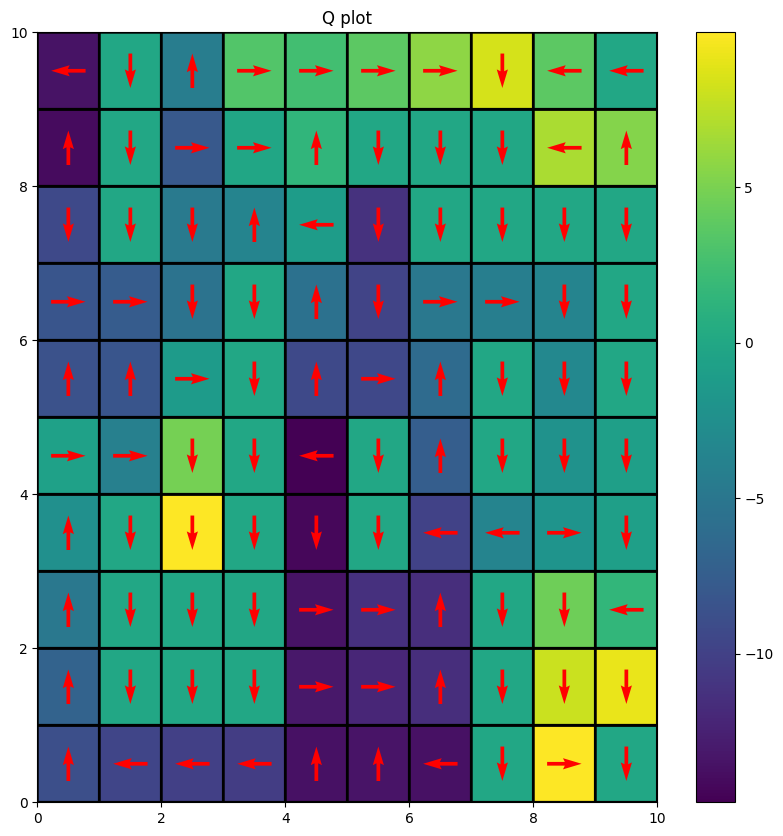

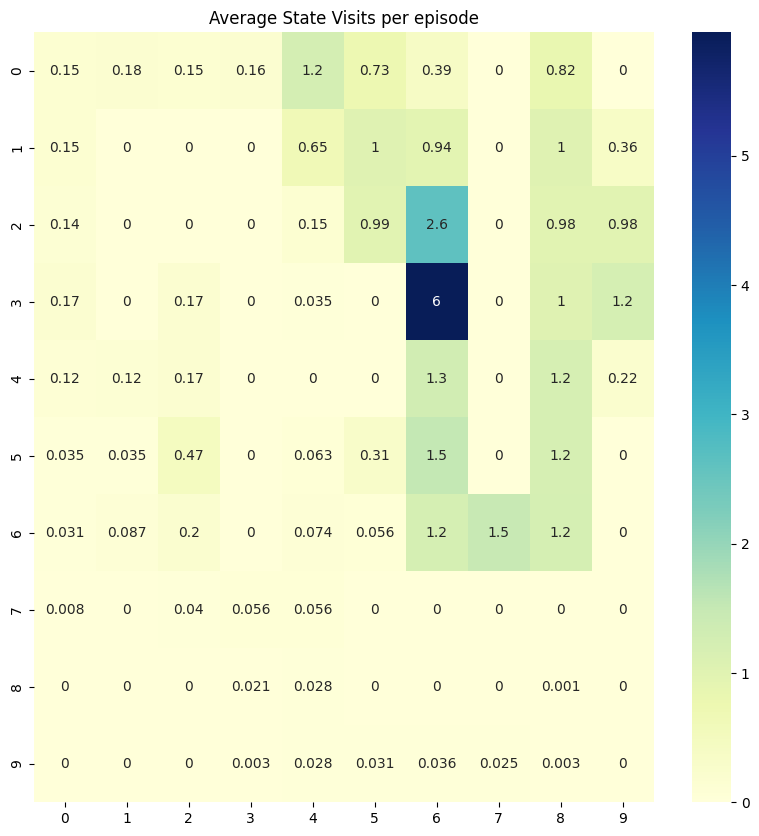

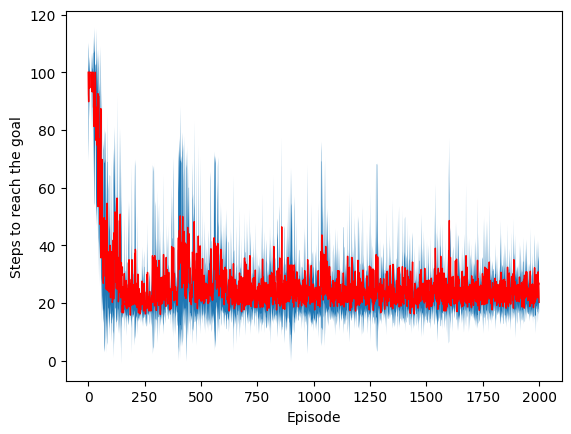

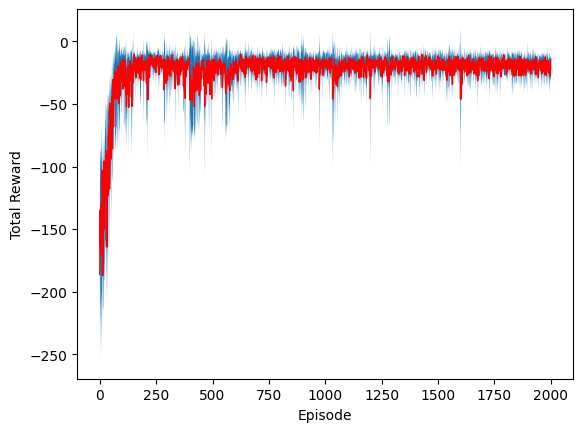

In [45]:
# wind = False, p = 0.7, b = 0.5, start_state = [0,4]
env = create_env(p_transition=0.7,b=0.5,wind=False,wind_prob = 0.4,start_state=[0,4])
final_ql(env,choose_action_softmax)

BEST_PARAMS are alpha: 0.3 gamma: 0.95 policy_param: 0.01


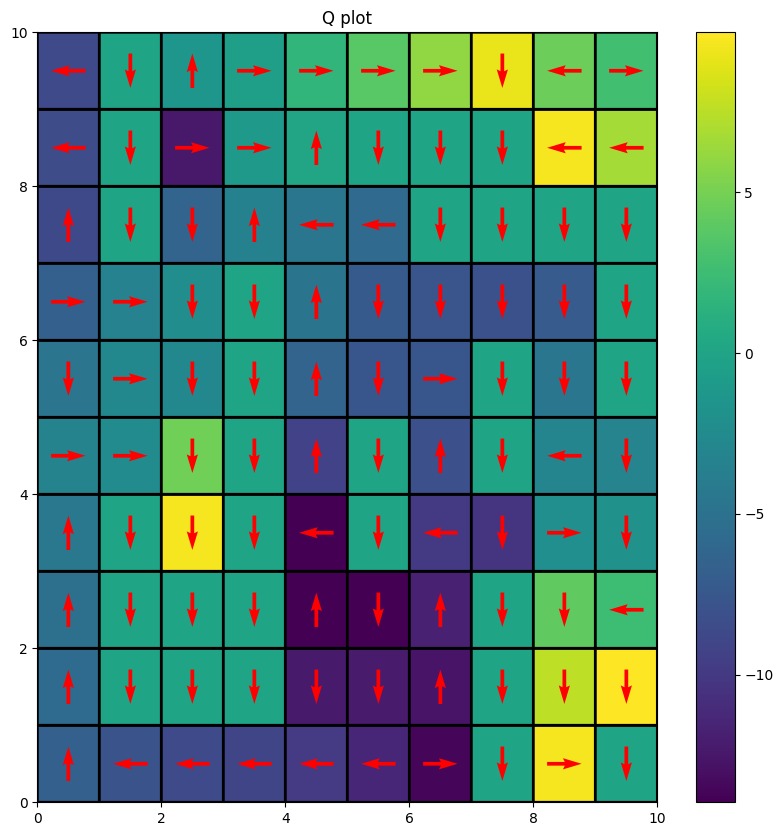

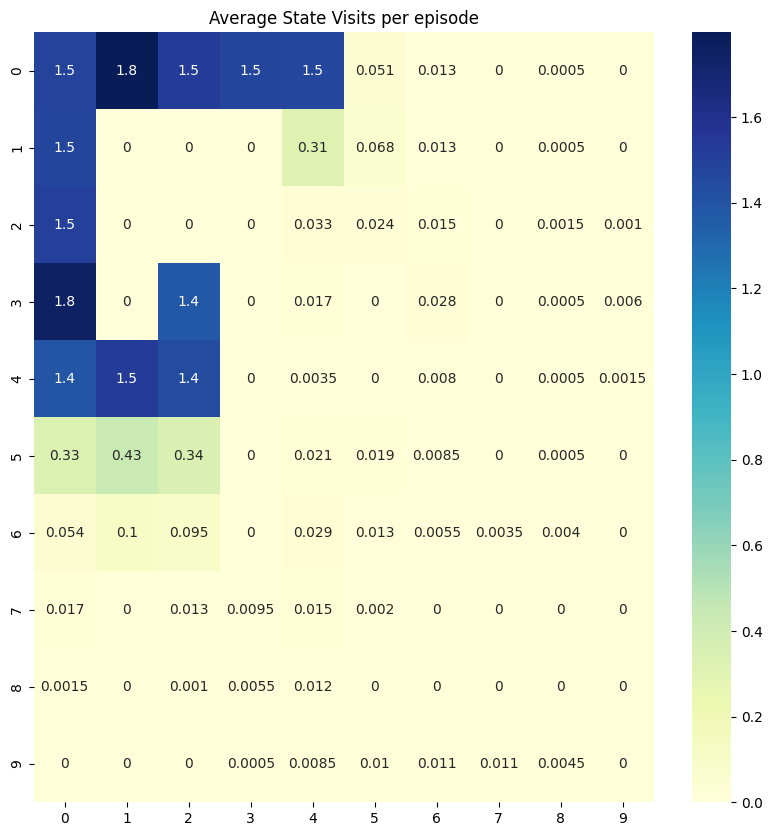

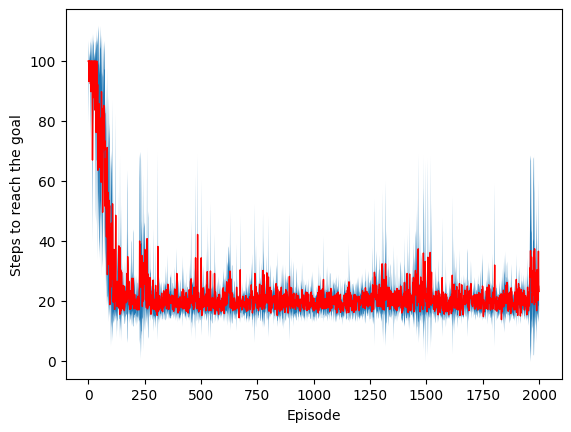

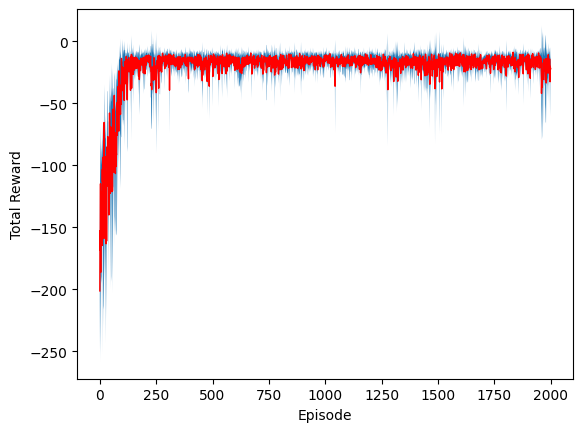

In [47]:
# wind = False, p = 0.7, b = 0.5, start_state = [0,4]
env = create_env(p_transition=0.7,b=0.5,wind=False,wind_prob = 0.4,start_state=[0,4])
final_ql(env,choose_action_epsilon)

BEST_PARAMS are alpha: 0.5 gamma: 0.95 policy_param: 0.05


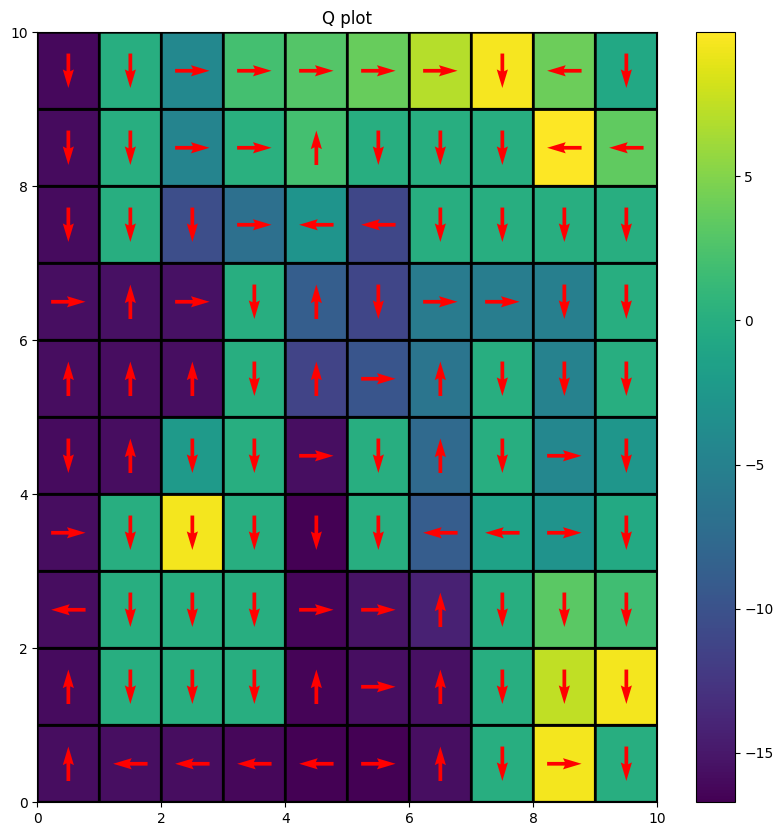

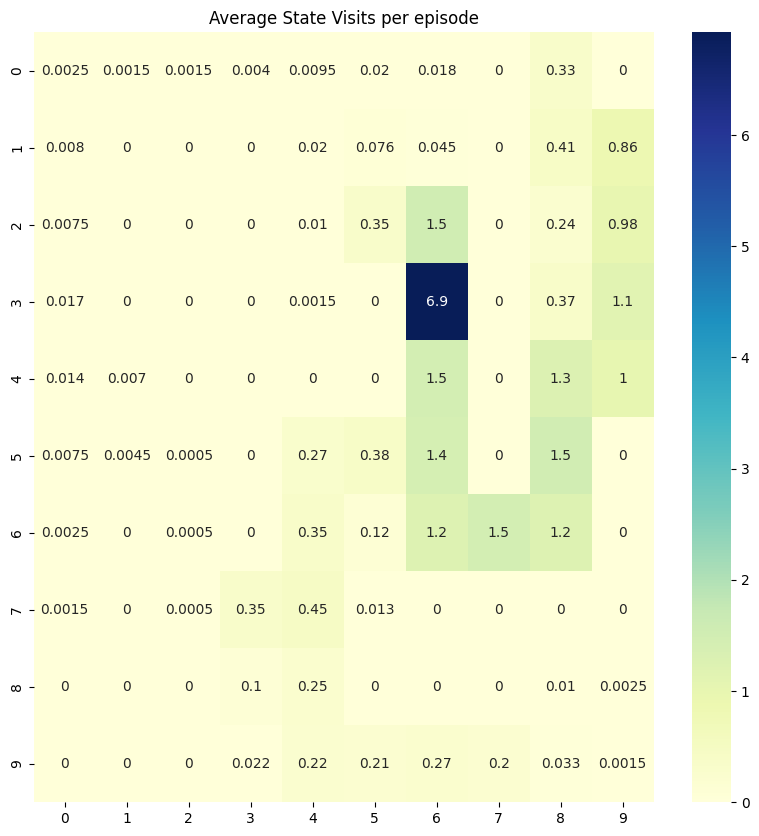

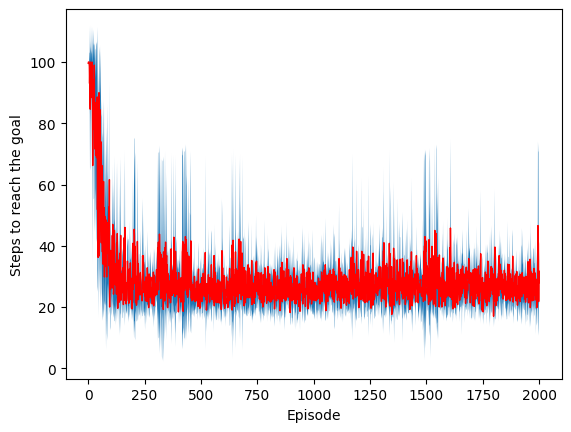

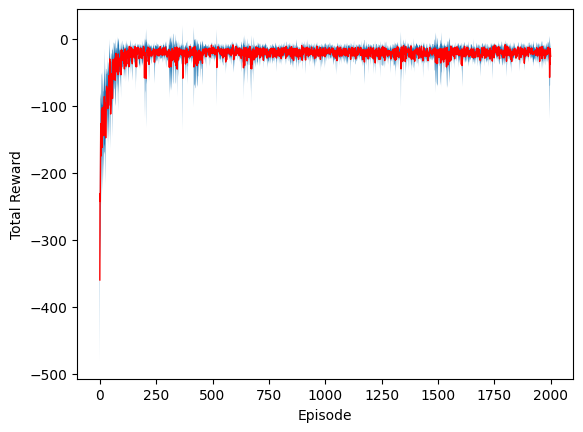

In [48]:
# wind = False, p = 0.7, b = 0.5, start_state = [3,6]
env = create_env(p_transition=0.7,b=0.5,wind=False,wind_prob = 0.4,start_state=[3,6])
final_ql(env,choose_action_softmax)

BEST_PARAMS are alpha: 0.3 gamma: 0.95 policy_param: 0.01


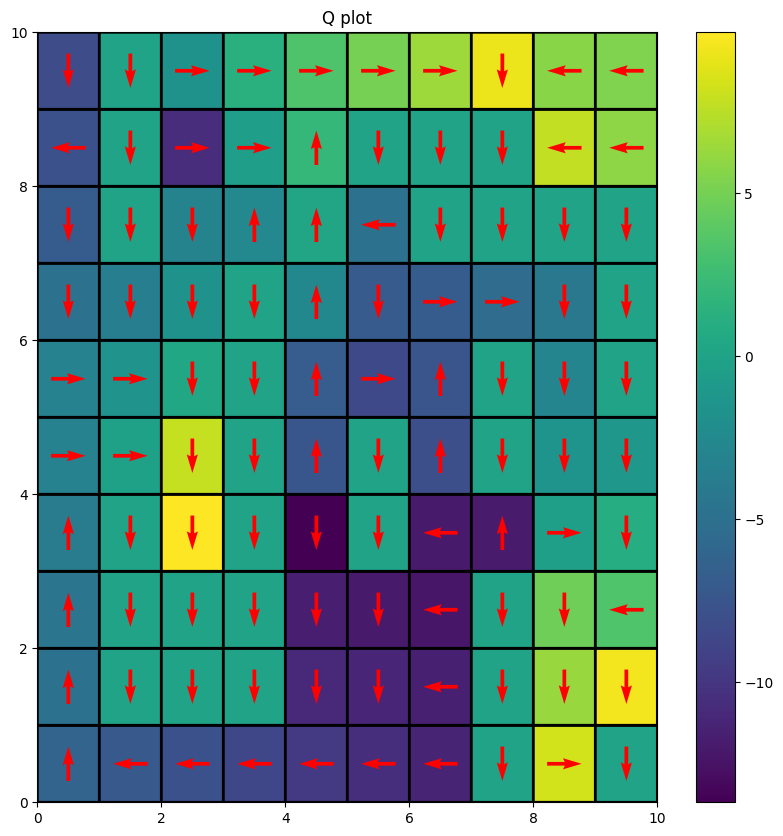

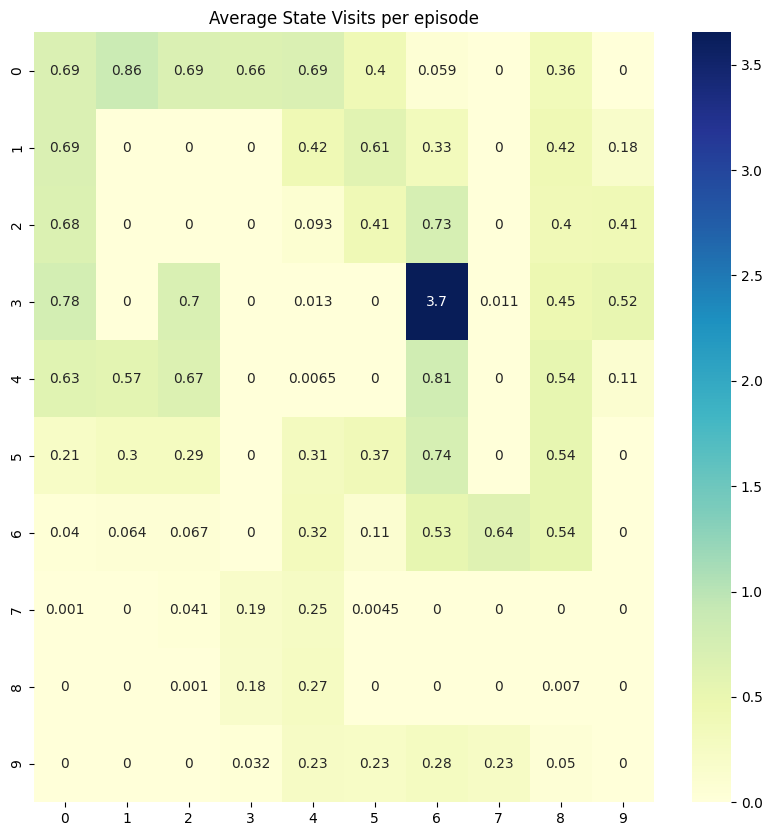

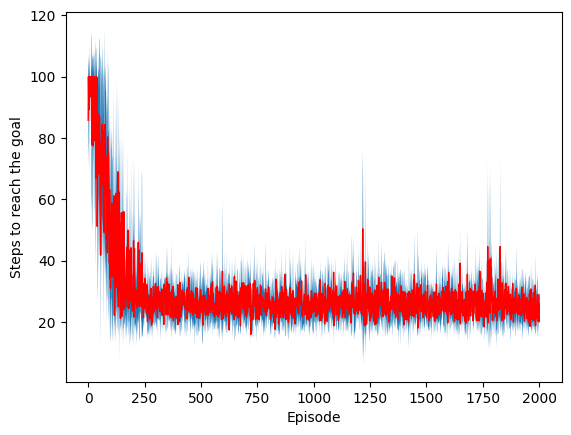

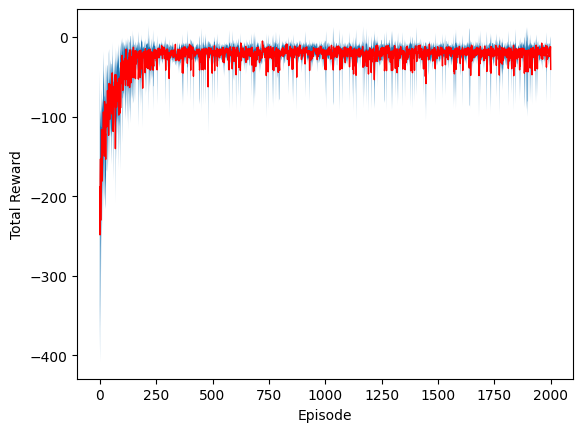

In [49]:
# wind = False, p = 0.7, b = 0.5, start_state = [0,4]
env = create_env(p_transition=0.7,b=0.5,wind=False,wind_prob = 0.4,start_state=[3,6])
final_ql(env,choose_action_epsilon)

BEST_PARAMS are alpha: 0.7 gamma: 0.95 policy_param: 0.01


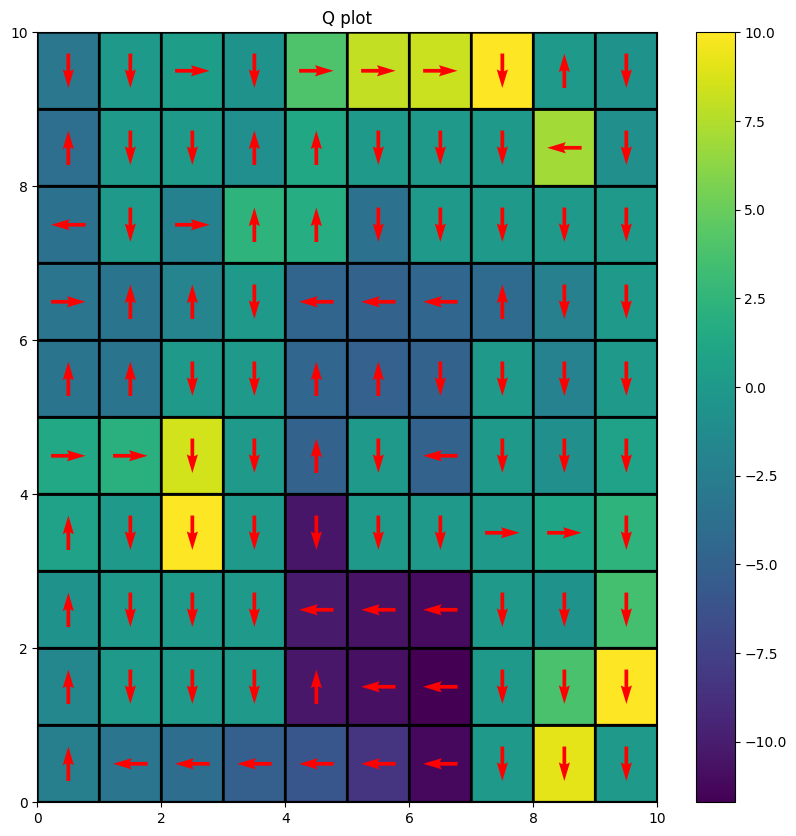

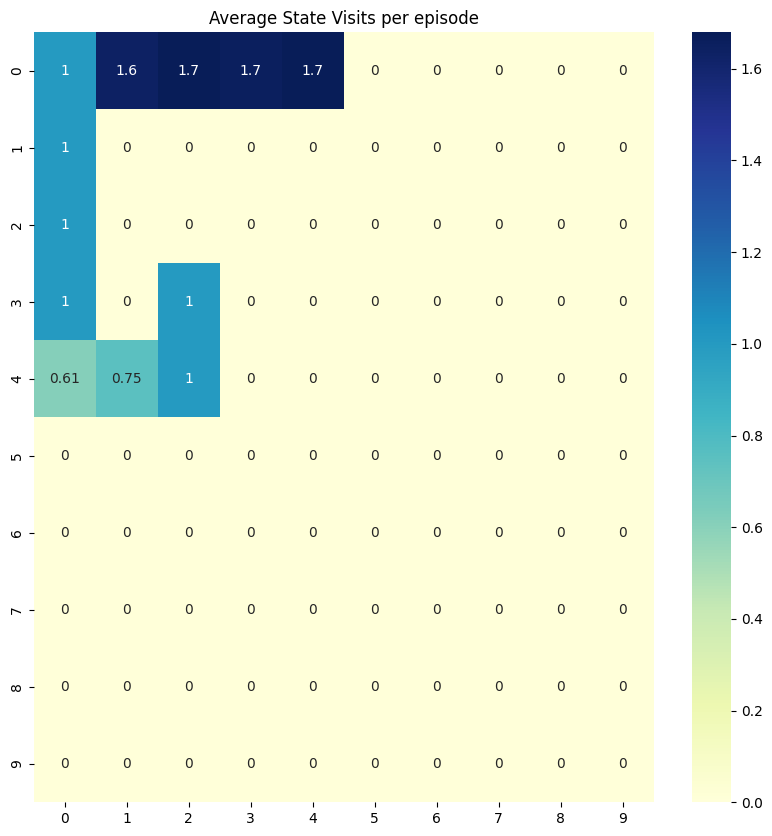

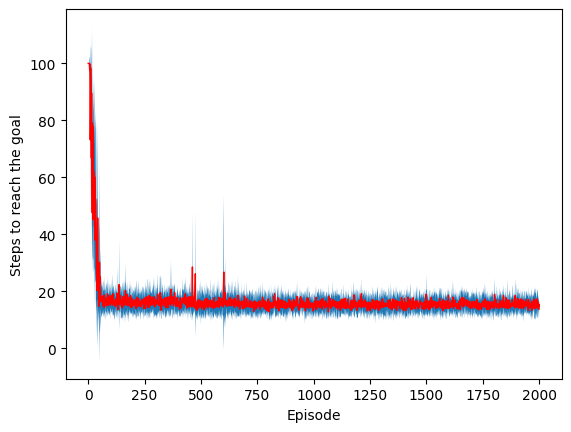

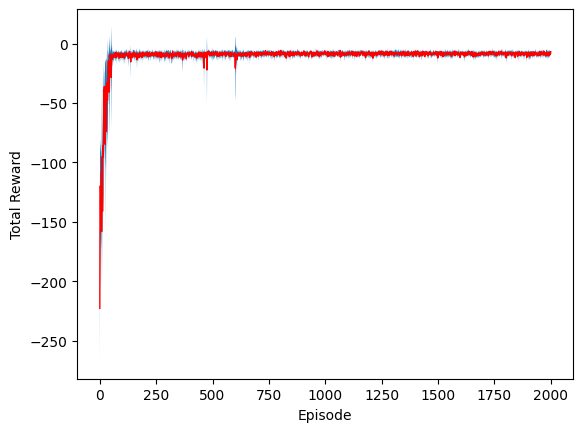

In [52]:
# wind = True, p = 1.0, b = 0.5, start_state = [0,4]
env = create_env(p_transition=1.0,b=0.5,wind=True,wind_prob = 0.4,start_state=[0,4])
final_ql(env,choose_action_softmax)

BEST_PARAMS are alpha: 0.7 gamma: 0.95 policy_param: 0.01


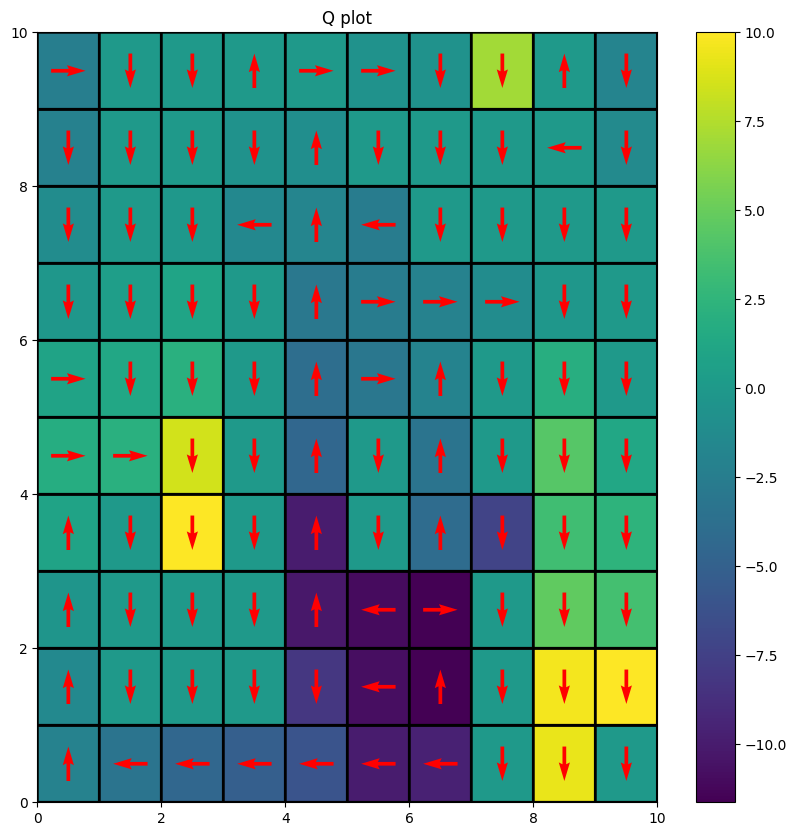

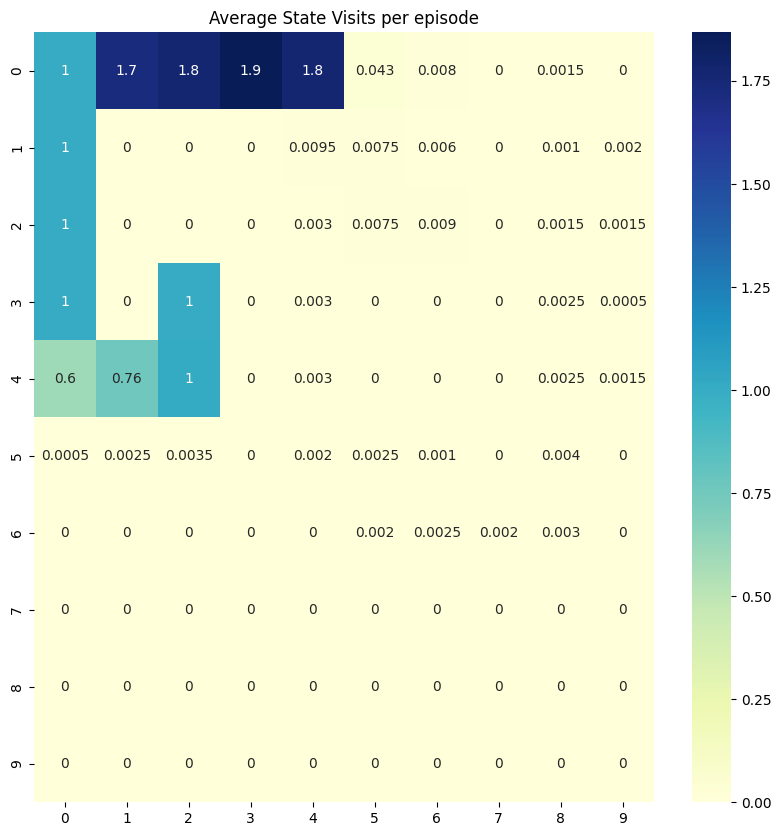

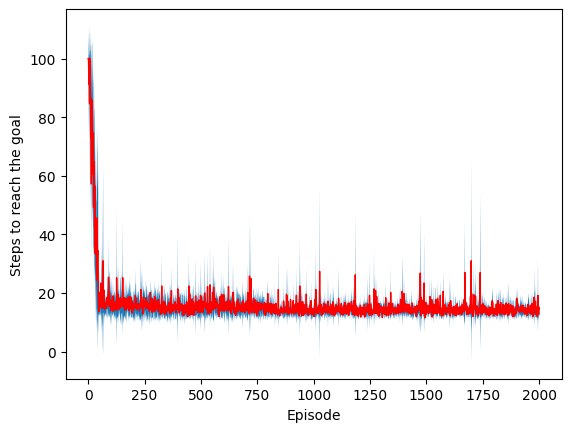

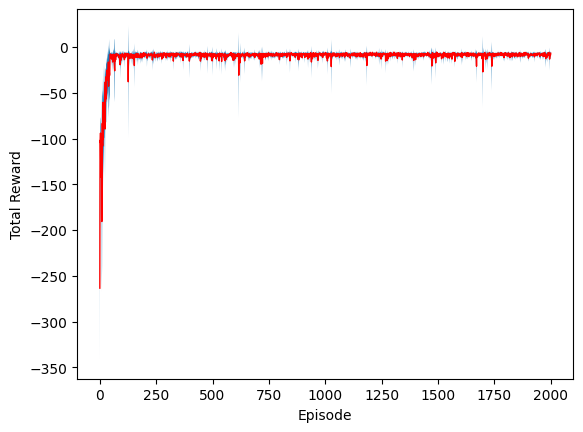

In [53]:
# wind = True, p = 1.0, b = 0.5, start_state = [0,4]
env = create_env(p_transition=1.0,b=0.5,wind=True,wind_prob = 0.4,start_state=[0,4])
final_ql(env,choose_action_epsilon)

BEST_PARAMS are alpha: 0.5 gamma: 0.7 policy_param: 0.01


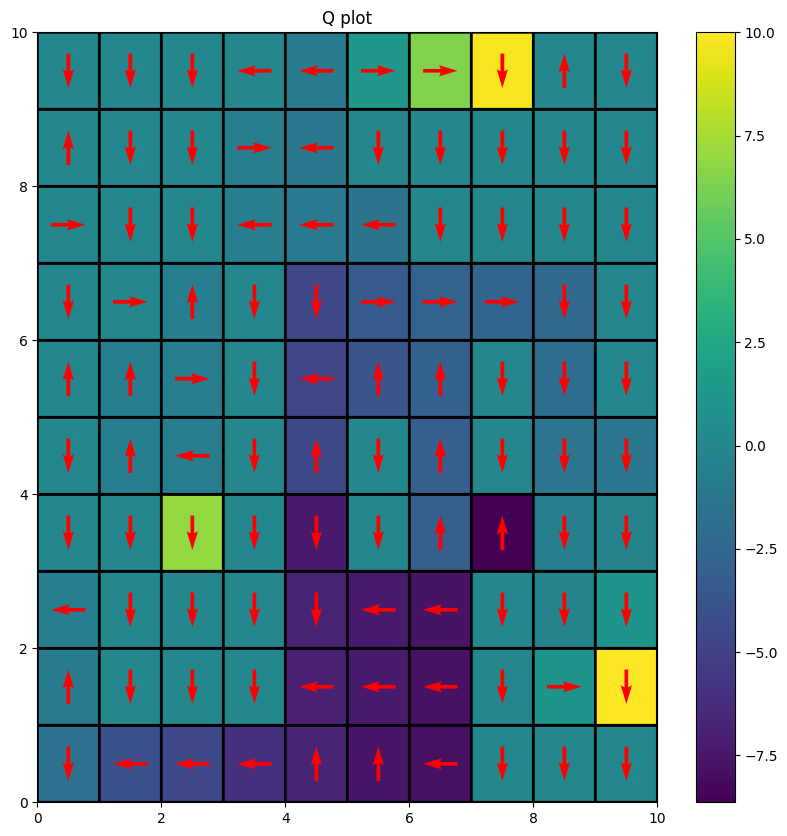

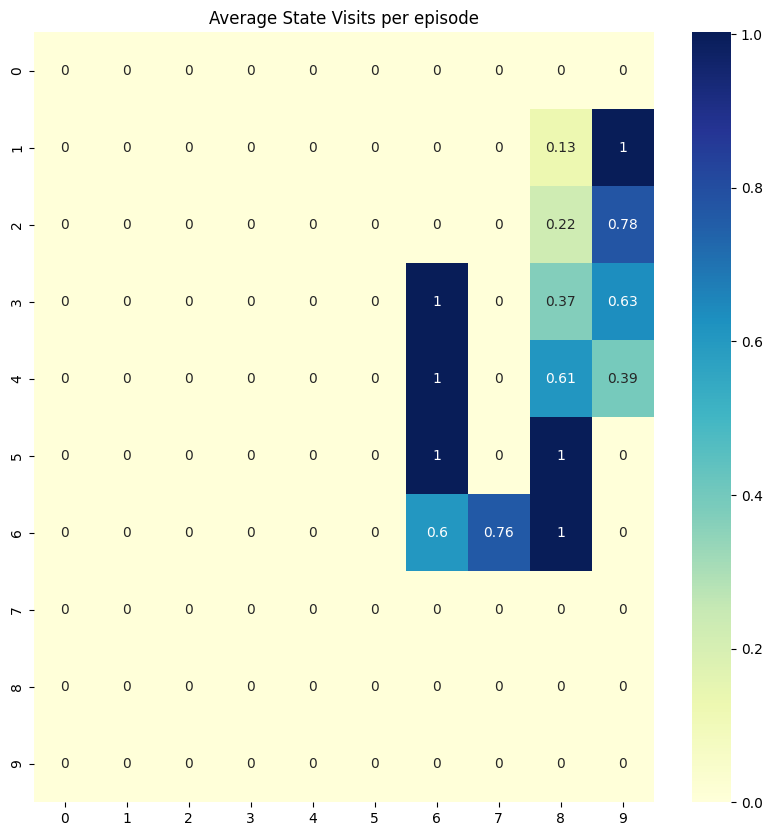

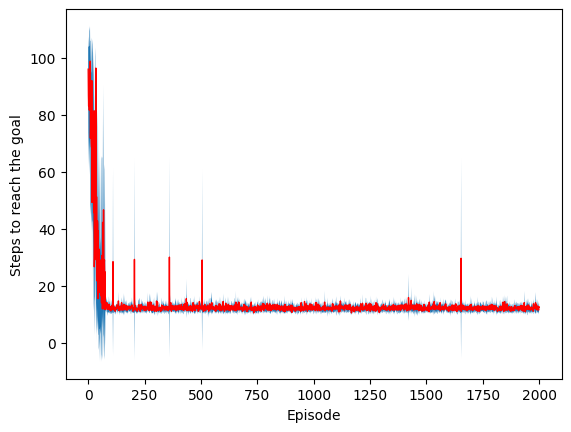

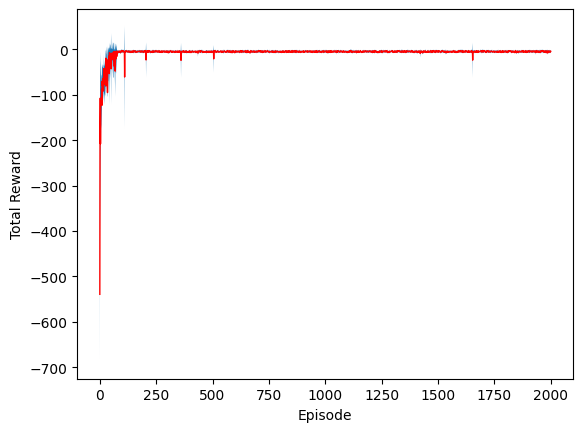

In [54]:
# wind = True, p = 1.0, b = 0.5, start_state = [3,6]
env = create_env(p_transition=1.0,b=0.5,wind=True,wind_prob = 0.4,start_state=[3,6])
final_ql(env,choose_action_softmax)

BEST_PARAMS are alpha: 0.7 gamma: 0.95 policy_param: 0.01


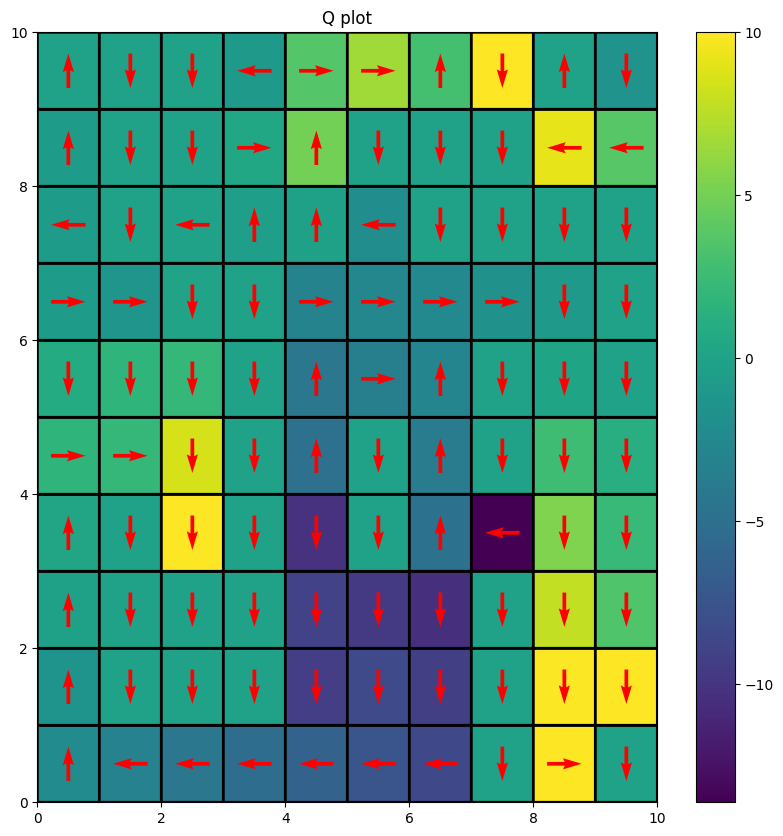

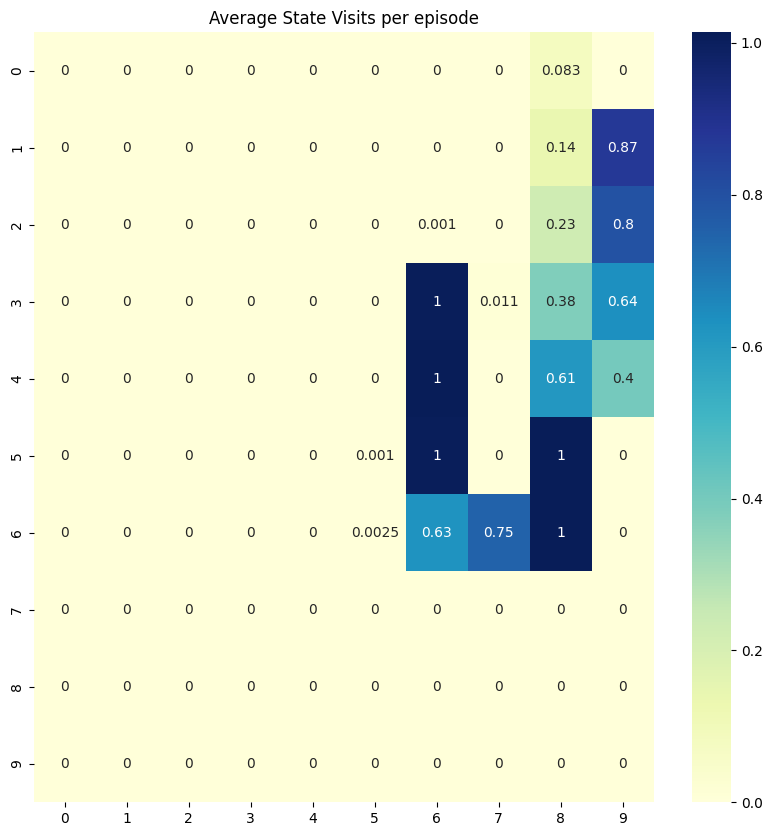

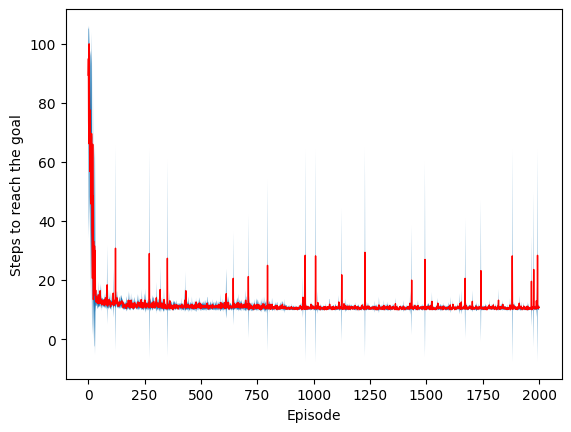

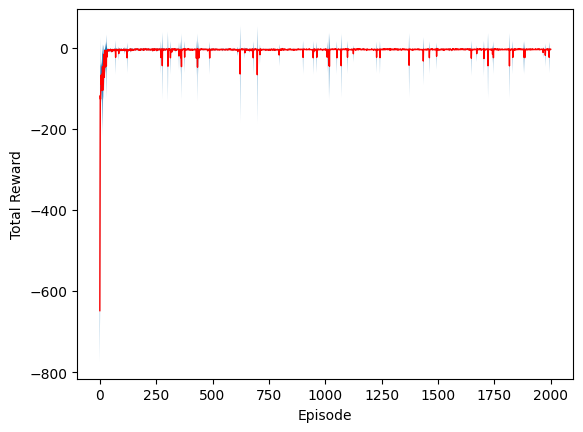

In [55]:
#wind = True, p = 1.0, b = 0.5, start_state = [3,6]
env = create_env(p_transition=1.0,b=0.5,wind=True,wind_prob = 0.4,start_state=[3,6])
final_ql(env,choose_action_epsilon)

BEST_PARAMS are alpha: 0.7 gamma: 0.95 policy_param: 0.05


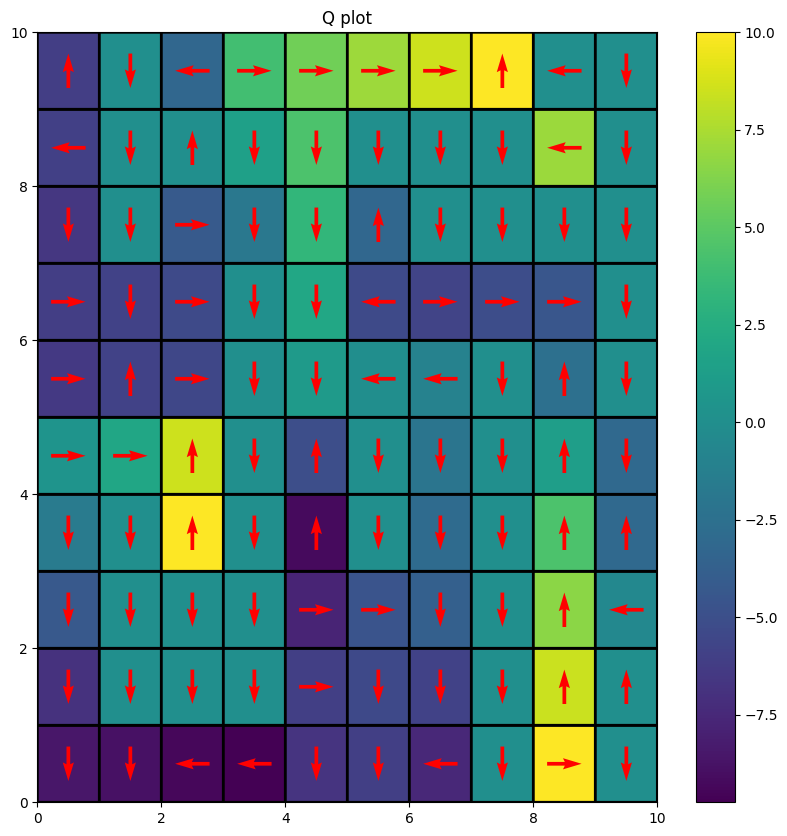

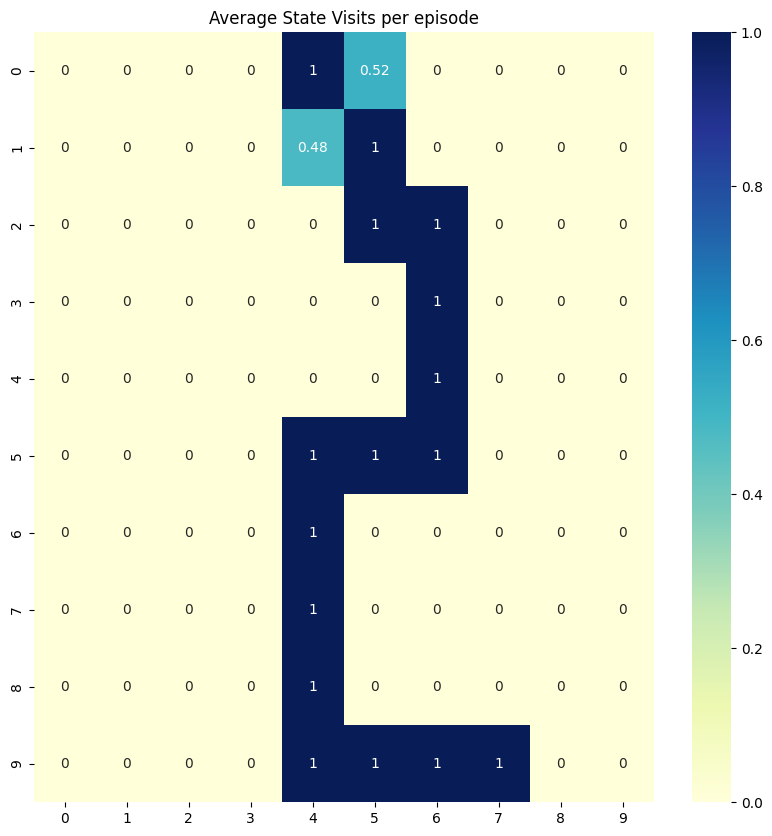

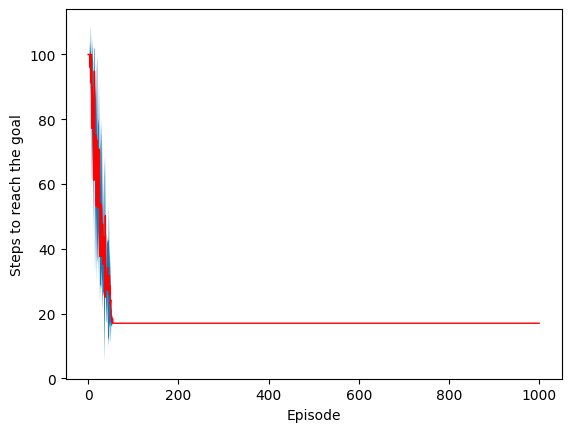

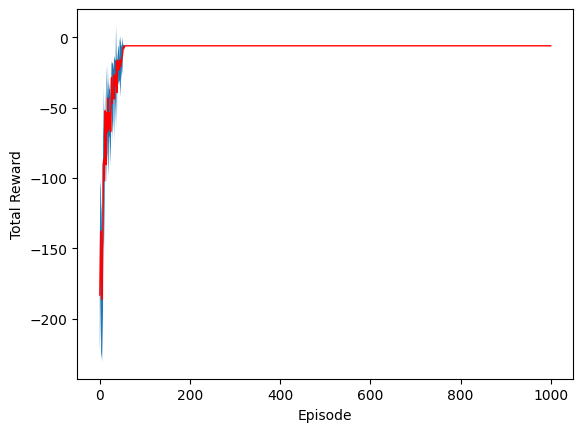

In [14]:
# wind = False, p = 1, b = 0.5, start_state = [0,4]
env = create_env(p_transition=1,b=0.5,wind=False,wind_prob= 0.4,start_state=[0,4])
final_ql(env,choose_action_softmax)

BEST_PARAMS are alpha: 0.7 gamma: 0.95 policy_param: 0.01


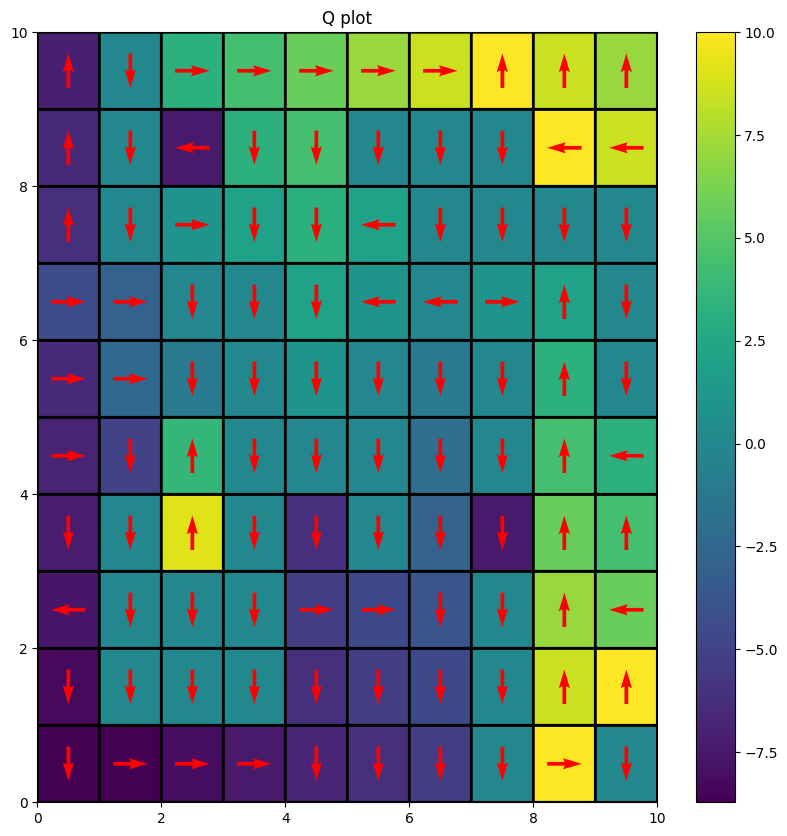

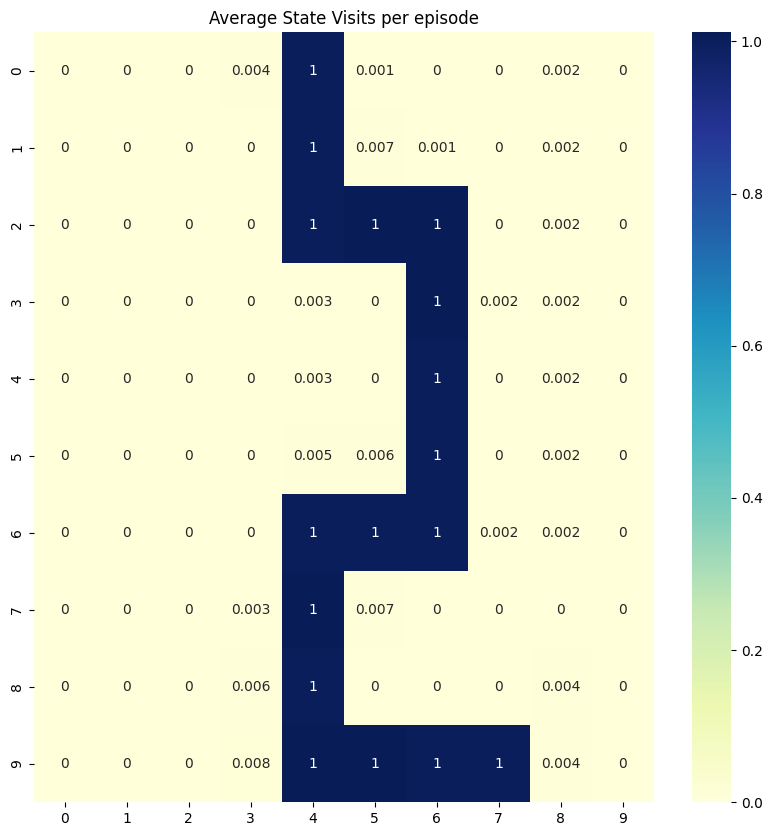

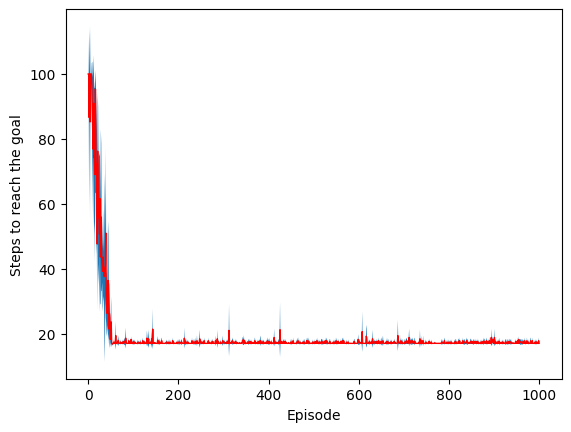

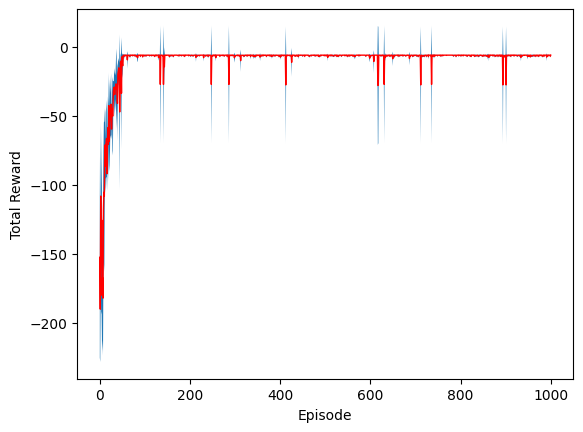

In [15]:
# wind = False, p = 1, b = 0.5, start_state = [0,4]
env = create_env(p_transition=1,b=0.5,wind=False,wind_prob=0.4,start_state=[0,4])
final_ql(env,choose_action_epsilon)

BEST_PARAMS are alpha: 0.7 gamma: 0.7 policy_param: 0.01


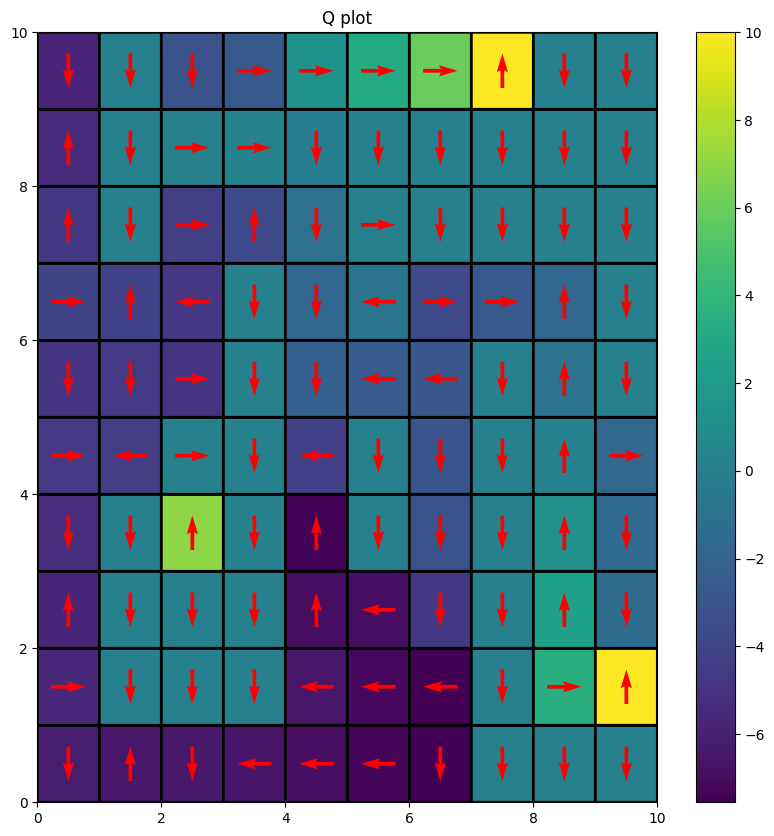

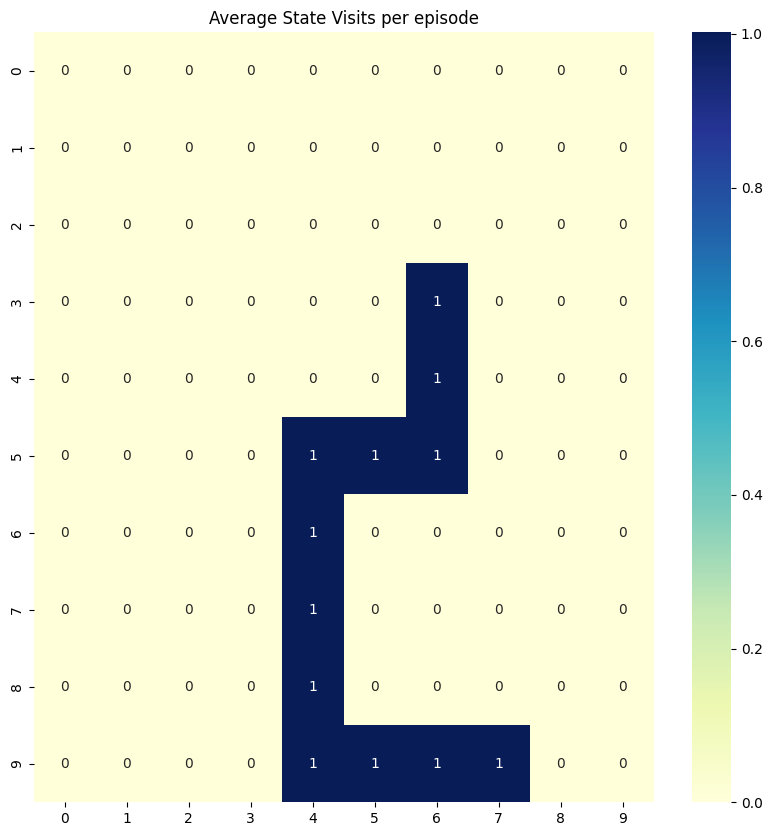

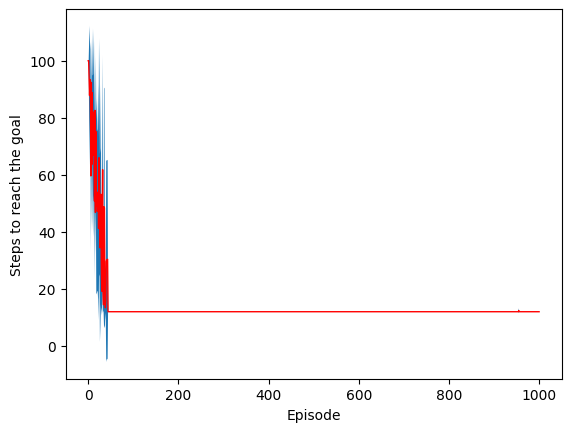

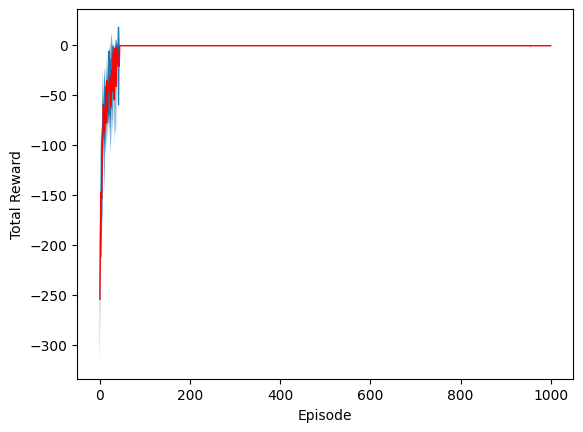

In [16]:
# wind = False, p = 1, b = 0.5, start_state = [3,6]
env = create_env(p_transition=1,b=0.5,wind=False,wind_prob = 0.4,start_state=[3,6])
final_ql(env,choose_action_softmax)

BEST_PARAMS are alpha: 0.7 gamma: 0.5 policy_param: 0.01


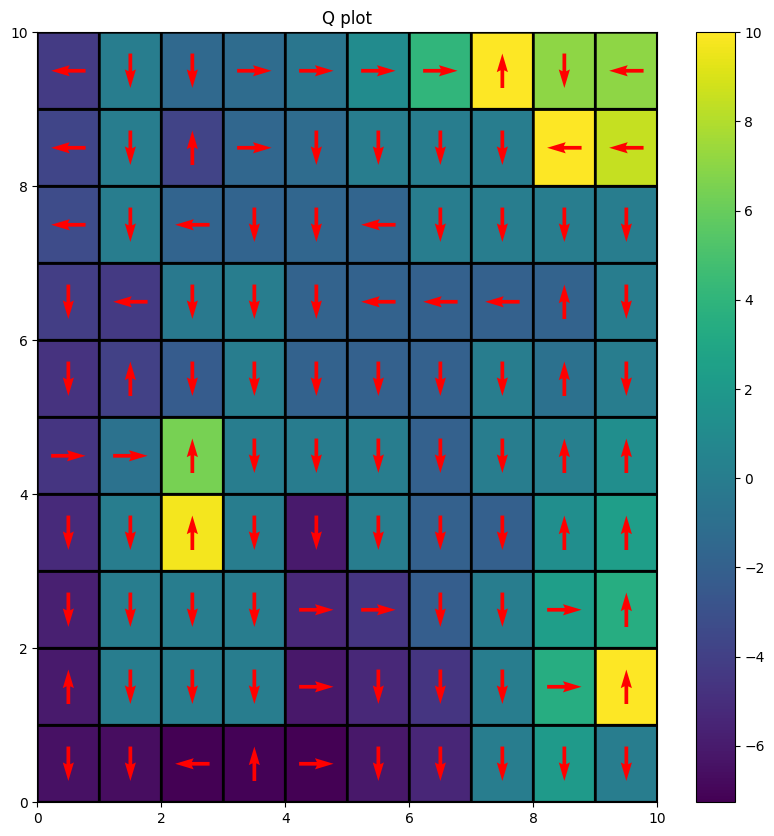

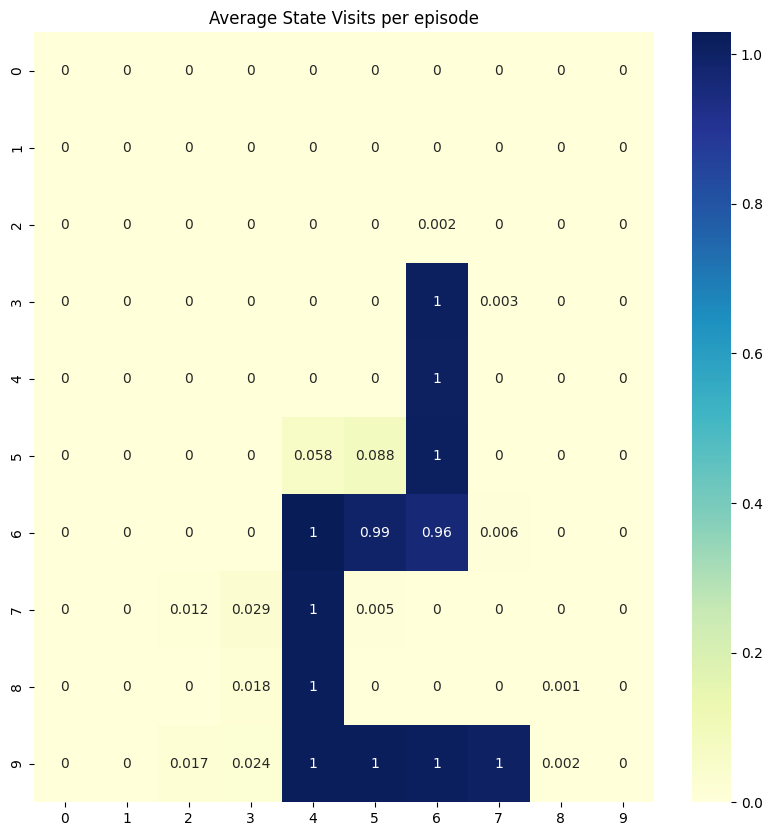

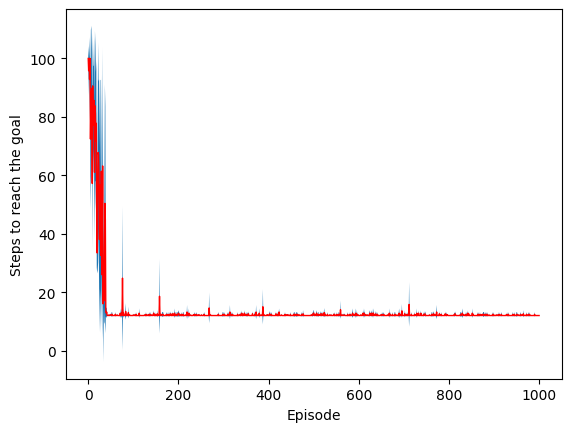

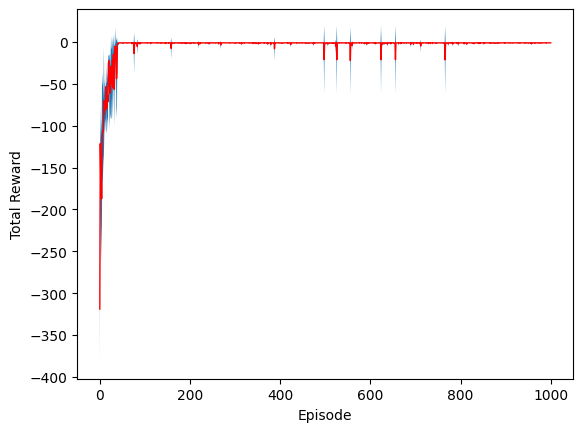

In [18]:
# wind = False, p = 1, b = 0.5, start_state = [3,6]
env = create_env(p_transition=1,b=0.5,wind=False,wind_prob=0.4,start_state=[3,6])
final_ql(env,choose_action_epsilon)